##DECISION TREE 
### FIND OUT THE COST OF TRANSPORT BY PROVIDOR 

Using Historical Data 2020 - 2022

We are going to use the next library for treatment the data:

In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

The Data that we are using

In [ ]:
data = pd.read_excel('/content/data_decision_tree_lm.xlsx')

A brief summary of the data uploaded:

In [ ]:
data.head()

,COD_MATERIAL,COD_PROV_POS,COD_COMPRA,COD_PROVEEDOR,MONTO
0,1003135,352138,3800000688,200015,0.13
1,1005856,352138,3800000688,200015,0.05
2,1004690,352138,3800000688,200015,1.29
3,1001725,352138,3800000688,200015,0.38
4,1002672,352138,3800000688,200015,0.04


In [ ]:
data.dtypes

COD_MATERIAL       int64
COD_PROV_POS       int64
COD_COMPRA         int64
COD_PROVEEDOR      int64
MONTO            float64
dtype: object

How I want to find out the best provider, I am using the code for the provider:

In [ ]:
feature_cols = [x for x in data.columns if x not in 'COD_PROV_POS']

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['COD_PROV_POS']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'COD_PROV_POS']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'COD_PROV_POS']

This is the functions to see the performance of my model:

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

I am using a decision tree regression , because I want to know the costs per provider:

In [ ]:

feature_cols = [x for x in data.columns if x != 'MONTO']

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'MONTO']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'MONTO']

We create the algorithm to show the max depth and features:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
dr = DecisionTreeRegressor().fit(X_train, y_train)

param_grid = {'max_depth':range(1, dr.tree_.max_depth+1, 2),
              'max_features': range(1, len(dr.feature_importances_)+1)}

GR_sugar = GridSearchCV(DecisionTreeRegressor(random_state=42),
                     param_grid=param_grid,
                     scoring='neg_mean_squared_error',
                      n_jobs=-1)

GR_sugar = GR_sugar.fit(X_train, y_train)

In [ ]:
GR_sugar

GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 34, 2),
                         'max_features': range(1, 5)},
             scoring='neg_mean_squared_error')

The number of nodes and the maximum depth of the tree. This tree has lots of nodes, which is not so surprising given the continuous data.

In [ ]:
GR_sugar.best_estimator_.tree_.node_count, GR_sugar.best_estimator_.tree_.max_depth

(45, 5)

The error on train and test data sets. Since this is continuous, we will use mean squared error.

In [ ]:
from sklearn.metrics import mean_squared_error

y_train_pred_gr_sugar = GR_sugar.predict(X_train)
y_test_pred_gr_sugar  = GR_sugar.predict(X_test)

train_test_gr_sugar_error = pd.Series({'train': mean_squared_error(y_train, y_train_pred_gr_sugar),
                                         'test':  mean_squared_error(y_test, y_test_pred_gr_sugar)},
                                          name='MSE').to_frame().T

train_test_gr_sugar_error

,train,test
MSE,0.94001,2.335508


In [ ]:
X_train,y_train_pred_gr_sugar

(      COD_MATERIAL  COD_PROV_POS  COD_COMPRA  COD_PROVEEDOR
 2195       1004889        352138  3800000688         200015
 2996       1029307        352138  3800000757         200015
 3351       1004951        352138  3800000757         200015
 2244       1026357        352184  3800002001         200008
 1821       1001374        352138  3800000757         200015
 ...            ...           ...         ...            ...
 1663       1015410        352138  3800000694         200015
 381        1007299        352138  3800000694         200015
 1390       1020509        350009  3800000932         200275
 3166       1066784        350009  3800001882         200232
 1565       1000024        352138  3800000824         200015
 
 [2838 rows x 4 columns],
 array([0.1516675 , 0.1516675 , 0.1516675 , ..., 0.61215385, 0.93486842,
        2.66      ]))

A plot of actual vs predicted Costs.

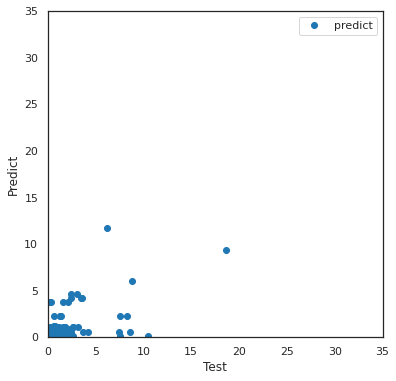

In [ ]:
sns.set_context('notebook')
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_predict = pd.DataFrame({'test':y_test.values,
                                'predict': y_test_pred_gr_sugar}).set_index('test').sort_index()

ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test', ylabel='Predict', xlim=(0,35), ylim=(0,35));
### END SOLUTION

This helps to find out the cost per provider to choose the cheap one.

In [ ]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_test_pred_gr_sugar})
df

,Actual,Predicted
748,0.11,0.612154
937,0.11,0.612154
3257,0.05,0.151668
3631,0.09,0.151668
502,0.17,0.151668
...,...,...
3323,0.07,0.151668
1303,0.43,0.612154
197,0.23,0.151668
2132,0.04,0.151668


### METODOLOGIA DIFERENTE

In [ ]:
X = data.drop('MONTO', axis=1)
y = data['MONTO']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
1239,2.53,1.060
3063,0.07,0.020
1047,0.06,0.085
1767,0.55,0.370
910,0.21,0.710
...,...,...
3524,0.14,0.020
338,0.02,0.010
483,0.04,0.125
3031,0.42,0.130


In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.3841710069444444
Mean Squared Error: 2.786083564814815
Root Mean Squared Error: 1.6691565429326318
